# Dota 2 TI 12

October 27 - 29, Seattle, Climate Pledge Arena

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as st
from tqdm import tqdm
import statsmodels.formula.api as smf

## Get The Data

Started with obtaining all the [premium matches from datdota](https://datdota.com/matches?tier=premium) as a CSV.

In [2]:
premium_matches = pd.read_csv('../data/premium_matches.csv')

In [3]:
premium_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Match ID         2500 non-null   int64  
 1   Series           2485 non-null   float64
 2   League           2500 non-null   int64  
 3   Start Date/Time  2500 non-null   object 
 4   Match Length     2500 non-null   object 
 5   Duration (secs)  2500 non-null   int64  
 6   Kills Score      2500 non-null   object 
 7   Unnamed: 7       2500 non-null   object 
 8   Winner           2500 non-null   object 
 9   Radiant Team     2500 non-null   object 
 10  Radiant Players  2500 non-null   object 
 11  Dire Team        2500 non-null   object 
 12  Dire Players     2500 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 254.0+ KB


First thing, convert Start Date/Time to datetime and then select the 'league' `15728` (TI 12).

Found out that some times are off (like 6:00 instead of 18:00). As a first pass, I decided to just look at the games played during the finals weekend. So October 27 - 29, Seattle, Climate Pledge Arena. That was a total of 10 series and I simply identified them by day.

In [4]:
premium_matches['Start Date/Time'] = pd.to_datetime(premium_matches['Start Date/Time'])

premium_matches = premium_matches.loc[premium_matches['League'] == 15728]

In [5]:
#premium_matches['Start Date/Time'].dt.date.unique()

# # note there's no events yet after 10/29
# finals_start = premium_matches['Start Date/Time'] >= pd.to_datetime('2023-10-27')
# finals_end = premium_matches['Start Date/Time'] <= pd.to_datetime('2023-10-29')

In [6]:
premium_matches.loc[premium_matches['Series'].isin([819833, 819879, 819908, 819927]), 'Match Day'] = 'Friday'
premium_matches.loc[premium_matches['Series'].isin([820160, 820236, 820265, 820276]), 'Match Day'] = 'Saturday'
premium_matches.loc[premium_matches['Series'].isin([820513, 820565]), 'Match Day'] = 'Sunday'

In [7]:
finals_matches = premium_matches.dropna(subset='Match Day').copy()

## Games Overall <a name='games_played'></a>

In [8]:
print('Total Matches over the weekend:', len(finals_matches))
print('For reference, min possible games', 9*2 +3, 'and max possible', 9*3 +5)
print(finals_matches['Match Day'].value_counts().sort_index())

Total Matches over the weekend: 24
For reference, min possible games 21 and max possible 32
Friday       9
Saturday    10
Sunday       5
Name: Match Day, dtype: int64


What are the odds of 24 games being played? I'll try to answer this question with a Monte Carlo sim!

In [9]:
# note since it's BO3, each team will have at least 1 game as radiant (or dire)
teams_list = finals_matches['Radiant Team'].unique()

These are my assumptions here:
- Start with slightly imbalanced win probability, at 53% plus or minus 2% (sigma)
- Each game is independent; could be because of hero picks (better/worst drafts, more comfortable), or because one team gets into the headspace of the other

possible extensions: 
- do the actual bracket
- games within series affect win probability for next one (+morale)

In [10]:
# to simulate multiple turnaments
sim_num = 1000000
simulations = []

for sim in tqdm(range(sim_num)):

    # reset variables in each sim
    series = [0, 0]
    series_win = 2
    series_num = 1
    tournament = []

    # simulate new win probabilities for each tournament (10 series)
    win_prob1 = np.random.normal(0.53, 0.02, 10)
    win_prob2 = 1 - win_prob1

    while True:

        # for the finals, 3 wins are needed for series
        if series_num == 10:
            series_win = 3

        # select 0 (first team wins) or 1 (second team wins)
        team_win = np.random.choice([0,1], p=[win_prob1[series_num - 1], win_prob2[series_num - 1]])

        # add a point in the series for winning team
        series[team_win] += 1

        # if the winning team won the series
        if series[team_win] == series_win:

            # save the series score
            tournament.extend(series)

            # start new series - aka reset variable
            series = [0, 0]

            # marks which series is being played
            series_num += 1

            # end the loop
            if series_num == 11:
                break
    
    # add to simulation
    simulations.append(tournament)


100%|██████████| 1000000/1000000 [03:13<00:00, 5166.58it/s]


In [11]:
#pd.DataFrame(np.array(tournament).reshape(1,-1))
simulations_df = pd.DataFrame(simulations)

In [12]:
sim_mean = simulations_df.sum(axis=1).mean()
sim_std = simulations_df.sum(axis=1).std()

# since there were 24 matches; note that Z-score is strictly less then
# since the actual possible values are integers, I'm looking for the probability
# that covers 24 games; so from 23.5 to 24.5
Z_observed_top = (24.5 - sim_mean) / sim_std
Z_observed_bot = (23.5 - sim_mean) / sim_std

In [13]:
print('mean:', sim_mean)
print('std:', sim_std)
#print('Z_obs:', Z_observed)
print('=================')
print(f'probability of there being 24 games is {100* (st.norm.cdf(Z_observed_top) - st.norm.cdf(Z_observed_bot)):.2f}%')

mean: 26.593248
std: 1.6918805137899935
probability of there being 24 games is 7.42%


Lucky me, about 7.4% chance that I got to see 24 games, lol!

In [14]:
print('Time spent watching the games (not including draft or other commentary):')
print(pd.to_timedelta(f"{finals_matches['Duration (secs)'].sum()}s"))

Time spent watching the games (not including draft or other commentary):
0 days 17:36:07


In [15]:
print('Average game length:', pd.to_timedelta(f"{finals_matches['Duration (secs)'].mean()}s"))
print('Std dev game length:', pd.to_timedelta(f"{finals_matches['Duration (secs)'].std()}s"))

Average game length: 0 days 00:44:00.291666667
Std dev game length: 0 days 00:15:12.931993237


Start looking at kills

In [16]:
finals_matches[['Radiant Kills', 'Dire Kills']] = finals_matches['Kills Score'].str.split('-', expand=True)

finals_matches = finals_matches.drop(columns=['Kills Score', 'Unnamed: 7'])

finals_matches['Radiant Kills'] = finals_matches['Radiant Kills'].astype(int)
finals_matches['Dire Kills'] = finals_matches['Dire Kills'].astype(int)

finals_matches['Total Kills'] = finals_matches['Radiant Kills'] + finals_matches['Dire Kills']

In [17]:
print('Radiant kills:', finals_matches['Radiant Kills'].sum())
print('Dire Kills:', finals_matches['Dire Kills'].sum())
print('Total Kills:', finals_matches['Total Kills'].sum())

Radiant kills: 617
Dire Kills: 563
Total Kills: 1180


In [18]:
finals_matches['Winner'].value_counts()

Dire       12
Radiant    12
Name: Winner, dtype: int64

The longer the game takes, the more kills there are!

In [19]:
finals_matches['Duration (mins)'] = round(finals_matches['Duration (secs)'] / 60, 2)

In [20]:
smf.ols('Q("Total Kills") ~ Q("Duration (mins)")', data = finals_matches).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("Total Kills")   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     40.77
Date:                Sat, 11 Nov 2023   Prob (F-statistic):           2.00e-06
Time:                        17:30:26   Log-Likelihood:                -83.432
No. Observations:                  24   AIC:                             170.9
Df Residuals:                      22   BIC:                             173.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               17.6923      5.204      3.400      0.003       6.900      28.485
Q("Duration (mins)")     0.7152      0.112      6.385      0.000       0.483       0.948
==============================================================================
Omnibus:                        2.673   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                1.433
Skew:                           0.575   Prob(JB):                        0.488
Kurtosis:                       3.331   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

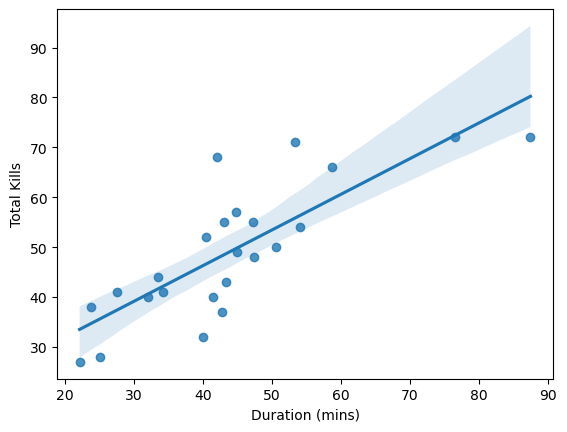

In [21]:
sns.regplot(data=finals_matches, x='Duration (mins)', y='Total Kills');

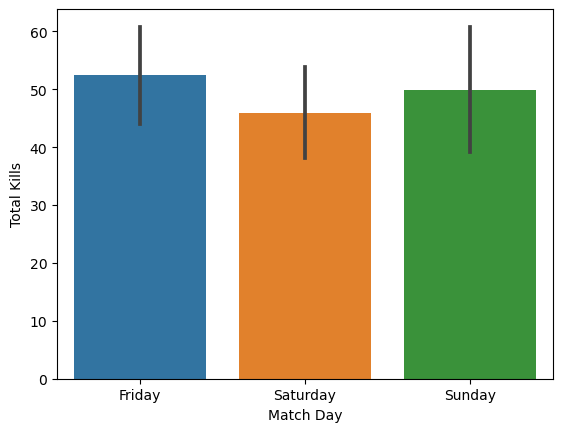

In [22]:
sns.barplot(finals_matches, x='Match Day', y='Total Kills', order=['Friday', 'Saturday', 'Sunday']);

Also length per day below.

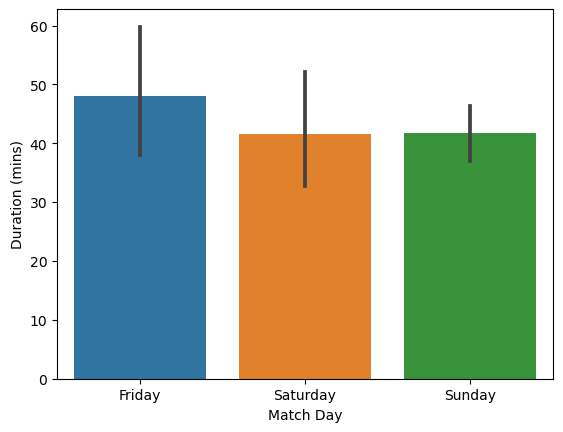

In [23]:
sns.barplot(finals_matches, x='Match Day', y='Duration (mins)', order=['Friday', 'Saturday', 'Sunday']);

How often does more kills mean the team wins?

In [24]:
finals_matches['Kill Difference'] = (
    np.where(finals_matches['Radiant Kills'] == finals_matches['Dire Kills'], 'Draw',
    np.where(finals_matches['Radiant Kills'] > finals_matches['Dire Kills'], 'Radiant', 'Dire'))
)

- When Radiant had the most kills, they won 100% of the time
- When the kills were equal, the Dire won
- When Dire had the most kills, they won 85% of the time

In [25]:
finals_matches.groupby(['Kill Difference', 'Winner'])['Match ID'].count()

Kill Difference  Winner 
Dire             Dire       11
                 Radiant     2
Draw             Dire        1
Radiant          Radiant    10
Name: Match ID, dtype: int64

In [26]:
print(f"Overall, the team that got most kills won {100*len(finals_matches.loc[finals_matches['Kill Difference'] == finals_matches['Winner']])/len(finals_matches)}% of time")


Overall, the team that got most kills won 87.5% of time


## Value of the Event

The next part is just for fun;

The official price of the tickets was $699, sold with Ticketmaster. Add to that:
- $5.55 (Order Processing Fee)
- $16.50 (Facility Charge)
- $151.45 (Service Fee)
- $7.58 (Tax)

And the final **actual** cost of tickets was $880.08

So let's say that I'm only interested in number of matches, or kills or total runtime; what is the "cost" of those? 

In [27]:
event_cost = 880.08

print('How much does it cost ...')
print(f"A Dota 2 game ${event_cost / len(finals_matches)}")
print(f"Each minute of a Dota 2 game ${event_cost * 60/ finals_matches['Duration (secs)'].sum():.2f}")
print(f"Each hour of a Dota 2 game ${event_cost * 3600/ finals_matches['Duration (secs)'].sum():.2f}")
print(f"Each kill in a Dota 2 game ${event_cost / finals_matches['Total Kills'].sum():.2f}")

How much does it cost ...
A Dota 2 game $36.67
Each minute of a Dota 2 game $0.83
Each hour of a Dota 2 game $50.00
Each kill in a Dota 2 game $0.75


What if I'm only paying (in my mind) for watching my team. How much will each of the matches they play cost?

The two extremes are:
- My team looses right away, in a 0:2 and gets eliminated
- My team wins all the way to the grand final, each series is a 2:1 and the finals ends in 3:2 (or 2:3, making me highly upset for my team)
- it could also happen that my team begins in the upper brackets, loses the first match 1:2 and then continues same as in the point above

So at least, they'll play 2 games, at most, 17 which is a massive difference! If we're paying per length of game, that's variable since it can be quite different (avg. is about 44 min and st dev. 15 min). For the sake of comparing extremes, for the sake of comparisons, I'll use the mean - std values for the team being eliminated right away, and mean + std for the team winning through (just to minimize and maximize time played). I'll compare that with the actual tournament least and most.

In [28]:
finals_matches

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Winner,Radiant Team,Radiant Players,Dire Team,Dire Players,Match Day,Radiant Kills,Dire Kills,Total Kills,Duration (mins),Kill Difference
0,7406531302,820565.0,15728,2023-10-30 12:13:00,42:05,2525,Dire,Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Team Spirit,"Larl, Miposhka, Mira, Collapse, Yatoro",Sunday,32,36,68,42.08,Dire
1,7406482053,820565.0,15728,2023-10-29 10:57:00,42:59,2579,Radiant,Team Spirit,"Larl, Miposhka, Mira, Collapse, Yatoro",Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Sunday,33,22,55,42.98,Radiant
2,7406424070,820565.0,15728,2023-10-29 09:47:00,33:27,2007,Dire,Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Team Spirit,"Larl, Miposhka, Mira, Collapse, Yatoro",Sunday,12,32,44,33.45,Dire
3,7406249246,820513.0,15728,2023-10-29 07:33:00,40:00,2400,Radiant,Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",LGD Gaming,"Y`, niu, PlAnet, NothingToSay, Shiro",Sunday,25,7,32,40.00,Radiant
4,7406129687,820513.0,15728,2023-10-29 06:09:00,50:31,3031,Dire,LGD Gaming,"Y`, niu, PlAnet, NothingToSay, Shiro",Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Sunday,23,27,50,50.52,Dire
5,7404938247,820276.0,15728,2023-10-29 06:09:00,23:43,1423,Radiant,Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Azure Ray,"Chalice, Fy, Somnus丶M, Yftx, lou",Saturday,33,5,38,23.72,Radiant
6,7404889653,820276.0,15728,2023-10-29 05:13:00,22:07,1327,Dire,Azure Ray,"Chalice, Fy, Somnus丶M, Yftx, lou",Gaimin Gladiators,"tOfu, Seleri, Ace, DyrachYO, CC&C",Saturday,9,18,27,22.12,Dire
7,7404828649,820265.0,15728,2023-10-29 03:45:00,47:13,2833,Dire,LGD Gaming,"Y`, niu, PlAnet, NothingToSay, Shiro",Team Spirit,"Larl, Miposhka, Mira, Collapse, Yatoro",Saturday,22,33,55,47.22,Dire
8,7404763579,820265.0,15728,2023-10-29 02:56:00,1:16:32,4592,Dire,LGD Gaming,"Y`, niu, PlAnet, NothingToSay, Shiro",Team Spirit,"Larl, Miposhka, Mira, Collapse, Yatoro",Saturday,35,37,72,76.53,Dire
9,7404713057,820236.0,15728,2023-10-29 01:31:00,42:49,2569,Dire,BetBoom Team,"Nightfall, Save-, Pure, TORONTOTOKYO, Gpk",Azure Ray,"Chalice, Fy, Somnus丶M, Yftx, lou",Saturday,17,20,37,42.82,Dire


In [29]:
team_stats =[]

for team_name in teams_list:

    team_matches = finals_matches.loc[(finals_matches['Radiant Team'] == team_name)| (finals_matches['Dire Team'] == team_name)].copy()
    
    team_radiant_games = len(finals_matches.loc[finals_matches['Radiant Team'] == team_name])
    team_dire_games = len(finals_matches.loc[finals_matches['Dire Team'] == team_name])

    team_radiant_wins = len(finals_matches.loc[((finals_matches['Radiant Team'] == team_name) & (finals_matches['Winner'] == 'Radiant'))])
    team_dire_wins = len(finals_matches.loc[((finals_matches['Dire Team'] == team_name) & (finals_matches['Winner'] == 'Dire'))])
    
    team_radiant_kills = finals_matches.loc[finals_matches['Radiant Team'] == team_name, 'Radiant Kills'].sum()
    team_radiant_deaths = finals_matches.loc[finals_matches['Radiant Team'] == team_name, 'Dire Kills'].sum()
    team_dire_kills = finals_matches.loc[finals_matches['Dire Team'] == team_name, 'Dire Kills'].sum()
    team_dire_deaths = finals_matches.loc[finals_matches['Dire Team'] == team_name, 'Radiant Kills'].sum()

    team_radiant_playtime = team_matches.loc[finals_matches['Radiant Team'] == team_name,'Duration (secs)'].sum()
    team_dire_playtime = team_matches.loc[finals_matches['Dire Team'] == team_name,'Duration (secs)'].sum()

    team_stats.append([team_name, team_radiant_games, team_dire_games,
                       round(100*team_radiant_wins/team_radiant_games,2),
                       round(100*team_dire_wins/team_dire_games,2),
                       round(team_radiant_kills/team_radiant_games,2), round(team_radiant_deaths/team_radiant_games,2),
                       round(team_dire_kills/team_dire_games,2), round(team_dire_deaths/team_dire_games,2),
                       round(team_radiant_playtime/(60*team_radiant_games),2),
                       round(team_dire_playtime/(60*team_dire_games),2),
                       team_radiant_playtime + team_dire_playtime])



In [30]:
team_stats = pd.DataFrame(team_stats, columns=['Team Name', 'Radiant Games', 'Dire Games', 'Radiant Win PCT', 'Dire Wins PCT', 'Radiant Kills Per Game', 'Radiant Deaths Per Game', 'Dire Kills Per Game', 'Dire Deaths Per Game', 'Team Radiant Play Time Per Game (mins)', 'Team Dire Play Time Per Game (mins)', 'Total Play Time (secs)'])

In [31]:
team_stats.columns[(team_stats.columns.str.contains('Radiant')) & (~team_stats.columns.str.contains('Radiant Games'))]

Index(['Radiant Win PCT', 'Radiant Kills Per Game', 'Radiant Deaths Per Game',
       'Team Radiant Play Time Per Game (mins)'],
      dtype='object')

In [32]:
team_stats

,Team Name,Radiant Games,Dire Games,Radiant Win PCT,Dire Wins PCT,Radiant Kills Per Game,Radiant Deaths Per Game,Dire Kills Per Game,Dire Deaths Per Game,Team Radiant Play Time Per Game (mins),Team Dire Play Time Per Game (mins),Total Play Time (secs)
0,Gaimin Gladiators,7,5,71.43,60.00,27.00,16.43,21.20,19.40,34.63,36.81,25587
1,Team Spirit,2,6,100.00,83.33,34.00,29.00,32.83,24.67,48.16,48.97,23409
2,LGD Gaming,3,3,0.00,66.67,26.67,32.33,25.00,20.67,58.09,44.04,18383
3,Azure Ray,4,3,25.00,33.33,19.25,30.25,10.00,28.33,43.23,32.85,16288
4,BetBoom Team,3,2,66.67,50.00,29.33,12.67,35.50,33.50,39.93,73.06,15955
5,Team Liquid,3,3,66.67,0.00,23.67,26.00,19.33,31.33,45.94,40.74,15604
6,Virtus.pro,1,1,0.00,0.00,36.00,36.00,13.00,36.00,87.43,44.97,7944
7,nouns,1,1,0.00,0.00,8.00,20.00,13.00,28.00,25.15,34.25,3564


Now let's break it down! First contrasting the least and most bang for your buck - measured in how much time a team has spent playing!

note to myself; contrast the actual, with the 

In [33]:
lp_time = team_stats['Total Play Time (secs)'].min()
lp_games = team_stats.loc[team_stats['Total Play Time (secs)'] == lp_time, 'Radiant Games'].iloc[0] + team_stats.loc[team_stats['Total Play Time (secs)'] == lp_time, 'Dire Games'].iloc[0]
lp_team = team_stats.loc[team_stats['Total Play Time (secs)'] == lp_time, 'Team Name'].iloc[0]

mp_time = team_stats['Total Play Time (secs)'].max()
mp_games = team_stats.loc[team_stats['Total Play Time (secs)'] == mp_time, 'Radiant Games'].iloc[0] + team_stats.loc[team_stats['Total Play Time (secs)'] == mp_time, 'Dire Games'].iloc[0]
mp_team = team_stats.loc[team_stats['Total Play Time (secs)'] == mp_time, 'Team Name'].iloc[0]

# theoretical lowest and highest
lt_games = 2
lt_time = lt_games * (finals_matches['Duration (secs)'].mean() - finals_matches['Duration (secs)'].std())
lt_team = 'TIS BUT A FLESH WOUND'

mt_games = 17
mt_time = mt_games * (finals_matches['Duration (secs)'].mean() + finals_matches['Duration (secs)'].std())
mt_team = 'YOLO'


pd.DataFrame({
    'Status': ['Theoretical Least Play Time', 'Least Play Time', 'Most Play Time', 'Theoretical Most Play Time'],
    'Team Name': [lt_team, lp_team, mp_team, mt_team],
    'Games Played': [lt_games, lp_games, mp_games, mt_games],
    'Time Played (mins)': [round(lt_time / 60, 2), round(lp_time / 60, 2), round(mp_time / 60, 2), round(mt_time / 60, 2)],
    'Cost per Game ($)': [round(event_cost / lt_games,2), round(event_cost / lp_games,2), round(event_cost / mp_games,2), round(event_cost / mt_games,2)],
    'Cost per Playtime ($/min)': [round(event_cost * 60/ lt_time,2), round(event_cost * 60/ lp_time,2), round(event_cost * 60 / mp_time,2), round(event_cost * 60/ mt_time,2)]
    })

,Status,Team Name,Games Played,Time Played (mins),Cost per Game ($),Cost per Playtime ($/min)
0,Theoretical Least Play Time,TIS BUT A FLESH WOUND,2,57.58,440.04,15.28
1,Least Play Time,nouns,2,59.40,440.04,14.82
2,Most Play Time,Gaimin Gladiators,12,426.45,73.34,2.06
3,Theoretical Most Play Time,YOLO,17,1006.75,51.77,0.87


In [34]:
finals_matches['Duration (secs)'].agg(['min', 'max', 'mean', 'std', 'median'])

min       1327.000000
max       5246.000000
mean      2640.291667
std        912.931993
median    2574.000000
Name: Duration (secs), dtype: float64

In [35]:
# prob. of the longest game (or longer)
100 - 100* st.norm.cdf((finals_matches['Duration (secs)'].max() - finals_matches['Duration (secs)'].mean())/finals_matches['Duration (secs)'].std())

0.2157135304701967

In [36]:
# prob. of the shortest game (or shorter)
100* st.norm.cdf((finals_matches['Duration (secs)'].min() - finals_matches['Duration (secs)'].mean())/finals_matches['Duration (secs)'].std())

7.514006362938523